I find myself often rewriting the same code that:
-  Passes some parameters to SLiM with the -d command.
-  Reads one (or several) files I generated somewhere else within a SLiM script.
-  Writing the same function in Eidos (so I can, for example, simulate a population size trajectory) and another language (so I can plot results).

This notebook shows how to use a minimal Python module one could copy-paste into their project. I think it could (a) reduce boilerplate code and (b) make it easier to share an analysis done in a Jupyter notebook with the regular workflow I tend to have.

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tskit
import pyslim
import msprime
from slimwrap import SLiMModel

In a nutshell, the module defines one class, `SLiMModel`, that can be used to interact with a SLiM script.

In [2]:
minimal_script = """
initialize() {
	initializeMutationRate(MU); // MU is passed as constant argument
	initializeMutationType("m1", 0.5, "f", 0.0);
	initializeGenomicElementType("g1", m1, 1.0);
	initializeGenomicElement(g1, 0, 99999);
	initializeRecombinationRate(1e-8);
}
1 early() {sim.addSubpop("p1", 500);}
1000 late() { p1.outputSample(10); }
2000 late() { p1.outputSample(10); }
2000 late() { sim.outputFixedMutations(); }
"""
model1 = SLiMModel(model_code=minimal_script)
model1.run(constants={"MU" : 1e-8})
model1

It is possible to define a new model from a file or by passing a string directly (as done above). To run the model, we make use of the `.run()` method (optionally passing a seed or one or more constant arguments). The method returns an instance of `CompletedProcess[bytes]` (from the `subprocess` standard library). The same instance can be accessed with the `.last_result` attribute.

When printed in a notebook, there is a minimally enriched display. This display shows the output and log of the SLiM script but also embeds the source code (which can be nice to share with collaborators).

## A more complete example
Next, I will do a simple analysis to show why I think having this sort of API could be useful. In particular, I aim to study the impact of population splits on genetic diversity using SLiM and `tskit`.

First, I define a `SLiMModel` from an external file. Notice that initializing the model would fail if there are any syntax errors. As you can see if you press the 'Show source code' button, the script is rather short and only defines a neutral mutation with tree sequence recording. The number of populations and their population size dynamics depend entirely on a matrix that we pass into the constant parameter.

In [3]:
model = SLiMModel(model_source="demo.slim")
model

Second, we define such population matrix. In order to compare metapopulations later, we have to re-scale the size of demes:

In [4]:
def sim_metapopulation_ne(seed, num_pops, generations):
    rng = np.random.default_rng(seed)
    total_mean = 5000
    total_std = 500
    total_Ne = rng.normal(loc=total_mean, scale=total_std, size=generations)
    proportions = rng.dirichlet(np.ones(num_pops))
    Ne_matrix = (total_Ne[:, None] * proportions[None, :]).T
    return Ne_matrix.astype(int)

In [5]:
seed = 1234
num_pops = 4
runtime = 5000
pop_sizes = sim_metapopulation_ne(seed, num_pops, runtime)
pop_sizes

array([[ 139,  167,  178, ...,  167,  163,  173],
       [2646, 3172, 3386, ..., 3183, 3094, 3294],
       [ 439,  526,  562, ...,  528,  514,  547],
       [ 972, 1165, 1243, ..., 1169, 1136, 1209]], shape=(4, 5000))

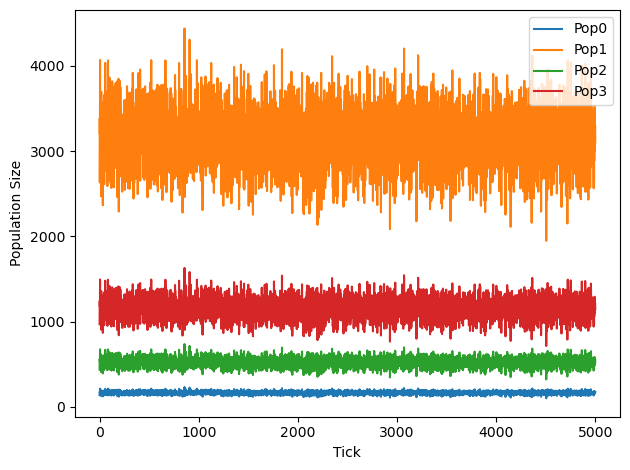

In [6]:
for i in range(pop_sizes.shape[0]):
    sns.lineplot(x=range(pop_sizes.shape[1]), y=pop_sizes[i, :], label=f"Pop{i}")

plt.xlabel("Tick")
plt.ylabel("Population Size")
plt.legend()
plt.tight_layout()
plt.show()

Third, we run the simulation passing the `pop_sizes` matrix as constant argument as well as the other arguments. Notice that the `python` types and dimensions are correctly maintained when passed to SLiM (or, at least, I tried so). 

In [7]:
params = {
    "L" : int(1e6-1), # Chromosome length
    "RHO" : 1e-8, # Recombination rate
    "popSizes" : pop_sizes,
    "OUTFILE" : "demo.trees"
}
model.run(seed=1234, constants=params)
ts = tskit.load("demo.trees")
ts

Now, we could use `recapitation` to simulate the prior history to the split and use the (fully-coalesced) tree sequence to compute different summary statistics. 

In [8]:
rts = pyslim.recapitate(
    pyslim.update(ts), # temporary trick I think
    recombination_rate=params["RHO"],
    # Taking as ancestral Ne the sum of all population
    # sizes at tick 0
    ancestral_Ne=sum(pop_sizes[:, 0]),
    random_seed=1234
)
mts = msprime.sim_mutations(rts, rate = 1e-8)
mts.diversity()

/Users/currocampuzano/Dev/slim-sublaunching/.pixi/envs/default/lib/python3.13/site-packages/pyslim/slim_metadata.py:936: UserWarning: This is a version 0.9 SLiM tree sequence. When you write this out, it will be converted to version 0.8.
  warnings.warn("This is a version {} SLiM tree sequence.".format(file_version) +
/Users/currocampuzano/Dev/slim-sublaunching/.pixi/envs/default/lib/python3.13/site-packages/msprime/ancestry.py:1290: TimeUnitsMismatchWarning: The initial_state has time_units=ticks but time is measured in generations in msprime. This may lead to significant discrepancies between the timescales. If you wish to suppress this warning, you can use, e.g., warnings.simplefilter('ignore', msprime.TimeUnitsMismatchWarning)
  sim = _parse_sim_ancestry(


np.float64(0.00022054406606563046)

Finally, once could encapsulate the whole analysis into a python function and run it in parallel. I think the amound of boiler plate is relatively low. 

In [9]:
import tempfile
import warnings
def simulate_diversity(args):
    seed, num_pops = args
    pop_sizes = sim_metapopulation_ne(seed, num_pops, runtime)
    # Create dictionary with arguments. We write the tree-sequence into a 
    # a temporary file:
    with tempfile.NamedTemporaryFile() as tmp:
        params = {
            "L" : int(1e6-1),"RHO" : 1e-8, "MU" : 1e-8, 
            "popSizes" : pop_sizes, "OUTFILE" : tmp.name
        }
        model = SLiMModel(model_source="demo.slim")
        # Simulations might fail because of a negative population size
        # We discard those runs:
        model.run(seed=seed, constants=params, check=False)
        if model.returncode == 1:
            return np.nan
        ts = tskit.load(tmp.name)
    with warnings.catch_warnings(action="ignore"):
        rts = pyslim.recapitate(
            pyslim.update(ts), recombination_rate=params["RHO"],
            ancestral_Ne=sum(pop_sizes[:, 0]),random_seed=seed
        )
        mts = msprime.sim_mutations(rts, rate = params["MU"])
    return mts.diversity()

Finally, one could compare the expected diversity for different number of splits by repeating the simulation process 100 times each. 

In [10]:
import concurrent
def analysis(num_pops, seeds):
    with concurrent.futures.ThreadPoolExecutor(max_workers=8) as executor:
        results = list(executor.map(simulate_diversity, [(seed, num_pops) for seed in seeds]))
    return np.array(results)
seeds = range(100, 200)
panmintic = analysis(1, seeds)
two_split = analysis(2, seeds)
ten_split = analysis(10, seeds)

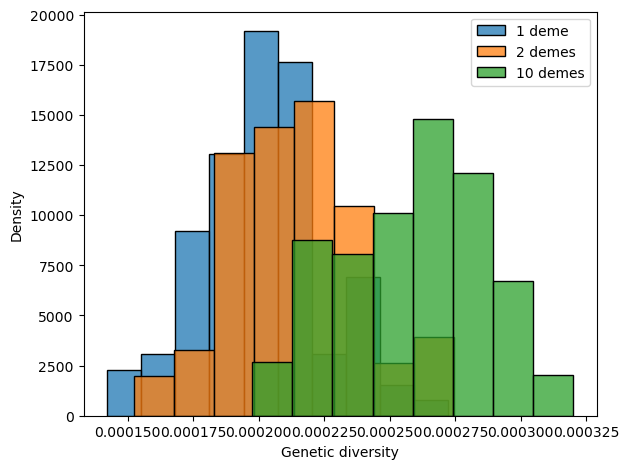

In [11]:
sns.histplot(panmintic, stat="density", label="1 deme")
sns.histplot(two_split, stat="density", label="2 demes")
sns.histplot(ten_split, stat="density", label="10 demes")
plt.xlabel("Genetic diversity")
plt.legend()
plt.tight_layout()
plt.show()